# Prepare

In [76]:
# machine learning modules
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import Binarizer

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer

from sklearn.neighbors import KNeighborsRegressor

In [2]:
# general modules
import pandas as pd
import sqlite3 
import os
import numpy as np
import pandas_profiling
import seaborn as sns
import sqlite3 as sql
import hashlib

import pickle

In [3]:
# variables
randon_state = 42

temp_path = 'temp'
pckl_train = 'train_data'
pckl_test = 'test_data'

# Import

In [4]:
train_in = open(os.path.join("..",temp_path, pckl_train),'rb')
df_train = pickle.load(train_in)
train_in.close()

In [5]:
test_in = open(os.path.join("..",temp_path, pckl_test),'rb')
df_test = pickle.load(test_in)
test_in.close()

In [6]:
df_train.columns

Index(['order_date', 'ship_date', 'ship_mode', 'customer_id', 'customer_name',
       'segment', 'city', 'state', 'country', 'postal_code', 'market',
       'region', 'product_id', 'category', 'sub-category', 'product_name',
       'sales', 'quantity', 'discount', 'profit', 'shipping_cost',
       'order_priority', 'returned', 'ship_delay'],
      dtype='object')

In [7]:
df_train

,order_date,ship_date,ship_mode,customer_id,customer_name,segment,city,state,country,postal_code,...,sub-category,product_name,sales,quantity,discount,profit,shipping_cost,order_priority,returned,ship_delay
index,,,,,,,,,,,,,,,,,,,,,
27507,2012-12-27,2012-12-31,Standard Class,SP-20860,a7d03c30d416fc5f7d695b495884fdd7,Corporate,Murfreesboro,Tennessee,United States,37130.0,...,Accessories,SanDisk Ultra 16 GB MicroSDHC Class 10 Memory ...,72.74400,7,0.200,-12.73020,6.720,Medium,No,4
35511,2014-12-25,2015-01-01,Standard Class,JD-15895,1b2850c124acd1bc24237b4b5228b65e,Corporate,Oosterhout,North Brabant,Netherlands,NaN,...,Labels,"Smead File Folder Labels, Adjustable",23.73000,7,0.500,-21.00000,3.430,Low,No,7
9172,2012-05-08,2012-05-11,Second Class,AB-10600,6acab08bb2b385c8569adfd24730ee01,Corporate,Phnom Penh,Phnom Penh,Cambodia,NaN,...,Bookcases,"Dania Corner Shelving, Pine",617.10000,5,0.000,172.65000,36.380,Medium,No,3
31366,2011-06-30,2011-07-02,Second Class,GH-14410,1528a0a296f3ecf500753855ea9a21a5,Home Office,Lima,Lima (city),Peru,NaN,...,Chairs,"Hon Bag Chairs, Red",54.18000,3,0.400,-32.52000,4.919,Medium,Yes,2
24465,2013-06-23,2013-06-26,First Class,KW-16435,648a7c6f93ee0f453ee1378466a84ff8,Consumer,London,England,United Kingdom,NaN,...,Storage,"Fellowes Box, Wire Frame",50.62500,3,0.100,20.20500,8.570,Medium,No,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,2014-07-10,2014-07-14,Second Class,PS-18970,c90d076ff45727789cb1742f443028e1,Home Office,Petapa,Guatemala,Guatemala,NaN,...,Bookcases,"Bush Corner Shelving, Metal",246.90000,3,0.000,32.04000,28.644,Medium,No,4
44732,2014-11-26,2014-12-02,Standard Class,CK-12205,8fe3138a7ef91d7f8635f63b9d5331ad,Consumer,Panama City,Panama,Panama,NaN,...,Labels,"Hon Round Labels, Alphabetical",15.55200,6,0.400,1.99200,1.281,Medium,No,6
38158,2011-10-14,2011-10-18,Second Class,LR-17035,a916b8bb7b9fcce602d0808e2eef7979,Corporate,Agra,Uttar Pradesh,India,NaN,...,Labels,"Hon Shipping Labels, Alphabetical",44.76000,4,0.000,20.04000,2.690,High,No,4


# Transform

## Creating features

## Feature selection

In [8]:
target_col = "ship_delay"

In [104]:
date_cols = ["order_date"]
num_cols = ["sales", "quantity", "profit", "shipping_cost"]
std_cols = ["discount"]

nomi_cols = ["segment", "market", "category", ]
ordi_cols = ["ship_mode", "order_priority"]


bin_cols = ["returned"]

unused_cols = ["ship_date", "customer_id", "customer_name", "city", "state" ,"country", "postal_code", "region", "product_id",
               "sub-category", "product_name"]



In [105]:
# check column count

used_cols_len = len(date_cols)+len(num_cols)+len(nomi_cols)+len(ordi_cols)+len(bin_cols)+len(unused_cols)+len(std_cols)+1

print("Total cols:", len(df_train.columns))
print("Considered cols:", used_cols_len)

Total cols: 24
Considered cols: 24


## X y split

In [106]:
def split_x_y(df):
    y = np.array(df[target_col])
    return df, y

In [107]:
X_train, y_train = split_x_y(df_train)

In [108]:
X_test, y_test = split_x_y(df_test)

## Pipeline

In [109]:
ordinal_categories = [
    ["Standard Class", "Second Class", "First Class", "Same Day"],
    ["Low", "Medium", "High", "Critical"]
]

In [110]:
ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)

In [111]:
std_pipeline = Pipeline([
    ("simple_imp", SimpleImputer())
])

In [112]:
num_pipeline = Pipeline([
    ("simple_imp", SimpleImputer()),
    ("pol", PolynomialFeatures()),
])

In [113]:
nomi_pipeline = Pipeline([
    ("one_hot", OneHotEncoder()),
])

In [114]:
bin_pipeline = Pipeline([
    ('one_hot_encoder', OneHotEncoder(sparse=False))
])

In [115]:
transform_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("nomi", nomi_pipeline, nomi_cols),
    ("ordi", ordinal_encoder, ordi_cols),
    ("bin", bin_pipeline, bin_cols),
    ("std", std_pipeline, std_cols)
])

In [116]:
simple_transform_pipeline = ColumnTransformer([
    ("log", log_pipeline, log_cols), 
    ("nomi", nomi_pipeline, nomi_cols),
    ("ordi", ordinal_encoder, ordi_cols),
    #("bin", bin_pipeline, bin_cols),
    #("std", std_pipeline, std_cols)
])

---


In [122]:
X_train_num = transform_pipeline.fit_transform(X_train)
X_test_num = transform_pipeline.fit_transform(X_test)
pd.DataFrame(X_train_num)

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,1.0,72.74400,7.0,-12.73020,6.720,5.291690e+03,509.20800,-926.045669,488.839680,49.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.200
1,1.0,23.73000,7.0,-21.00000,3.430,5.631129e+02,166.11000,-498.330000,81.393900,49.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.500
2,1.0,617.10000,5.0,172.65000,36.380,3.808124e+05,3085.50000,106542.315000,22450.098000,25.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.000
3,1.0,54.18000,3.0,-32.52000,4.919,2.935472e+03,162.54000,-1761.933600,266.511420,9.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.400
4,1.0,50.62500,3.0,20.20500,8.570,2.562891e+03,151.87500,1022.878125,433.856250,9.0,...,0.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,0.100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38466,1.0,246.90000,3.0,32.04000,28.644,6.095961e+04,740.70000,7910.676000,7072.203600,9.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.000
38467,1.0,15.55200,6.0,1.99200,1.281,2.418647e+02,93.31200,30.979584,19.922112,36.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.400
38468,1.0,44.76000,4.0,20.04000,2.690,2.003458e+03,179.04000,896.990400,120.404400,16.0,...,0.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,0.0,0.000
38469,1.0,1003.34928,4.0,178.94928,219.533,1.006710e+06,4013.39712,179548.631245,220268.277486,16.0,...,1.0,0.0,0.0,0.0,1.0,2.0,3.0,0.0,1.0,0.002


In [123]:
X_train_simple = transform_pipeline.fit_transform(X_train)
X_test_simple = transform_pipeline.fit_transform(X_test)
pd.DataFrame(X_test_simple)

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,1.0,69.120,9.0,-14.6880,5.480,4777.574400,622.080,-1015.234560,378.777600,81.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.2
1,1.0,31.200,1.0,4.0500,1.250,973.440000,31.200,126.360000,39.000000,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,97.272,2.0,-17.8480,6.841,9461.841984,194.544,-1736.110656,665.437752,4.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.4
3,1.0,31.140,3.0,2.4300,3.570,969.699600,93.420,75.670200,111.169800,9.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
4,1.0,7.056,3.0,2.2050,1.110,49.787136,21.168,15.558480,7.832160,9.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12819,1.0,100.792,1.0,6.2995,8.210,10159.027264,100.792,634.939204,827.502320,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.2
12820,1.0,99.200,5.0,25.7920,16.360,9840.640000,496.000,2558.566400,1622.912000,25.0,...,0.0,1.0,0.0,1.0,0.0,1.0,3.0,1.0,0.0,0.0
12821,1.0,26.400,5.0,11.8800,3.760,696.960000,132.000,313.632000,99.264000,25.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
12822,1.0,14.550,1.0,3.1800,1.750,211.702500,14.550,46.269000,25.462500,1.0,...,0.0,0.0,0.0,1.0,0.0,2.0,2.0,1.0,0.0,0.0


### KNearest

In [120]:
regression_pipeline = Pipeline([
    ("transform", transform_pipeline),
    ("knearest", KNeighborsRegressor(n_neighbors=7)),
])


In [91]:
model = regression_pipeline.fit(X_train, y_train)
model.score(X_train, y_train)

0.7913598835585687

In [92]:
model = regression_pipeline.fit(X_train, y_train)
model.score(X_test, y_test)

0.7115669351273292

### Complex

In [124]:
n = []
train1 = [] 
test1 = []

In [125]:
def test_model(n_neighbors):
    
    n.append(n_neighbors)
    
    model = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X_train_num, y_train)
    train_score = model.score(X_train_num, y_train)
    test_score = model.score(X_test_num, y_test)
    
    train1.append(train_score)
    test1.append(test_score)
    
    model = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X_train_num, y_train)
    train_score = model.score(X_train_simple, y_train)
    test_score = model.score(X_test_simple, y_test)
    
    train2.append(train_score)
    test2.append(test_score)

In [126]:
test_range = 15

for i in range(test_range):
    test_model(i+1)

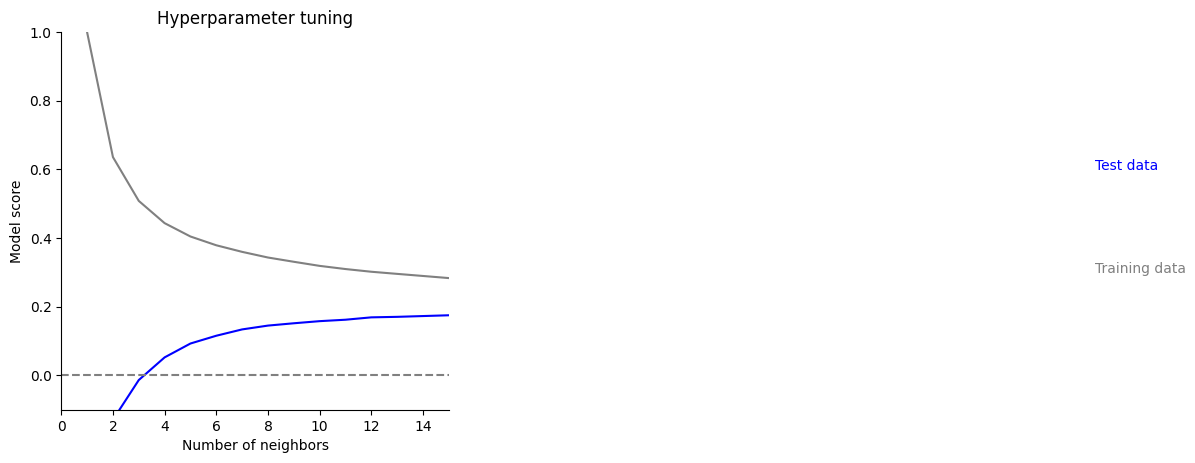

In [135]:
import matplotlib.pyplot as plt
plt.rc("axes.spines", top=False, right=False)
plt.rcParams['figure.figsize'] = [5,5]
plt.rcParams['figure.dpi'] = 100

plt.plot(n, train1, color="grey")
plt.plot(n, test1, color="blue")
plt.plot([0, test_range], [0, 0], color="grey", linestyle="--")
plt.xlim([0, test_range])
plt.ylim([-.1, 1])
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.text(40, .3, "Training data", color="grey")
plt.text(40, .6, "Test data", color="blue")
plt.title("Hyperparameter tuning")
None

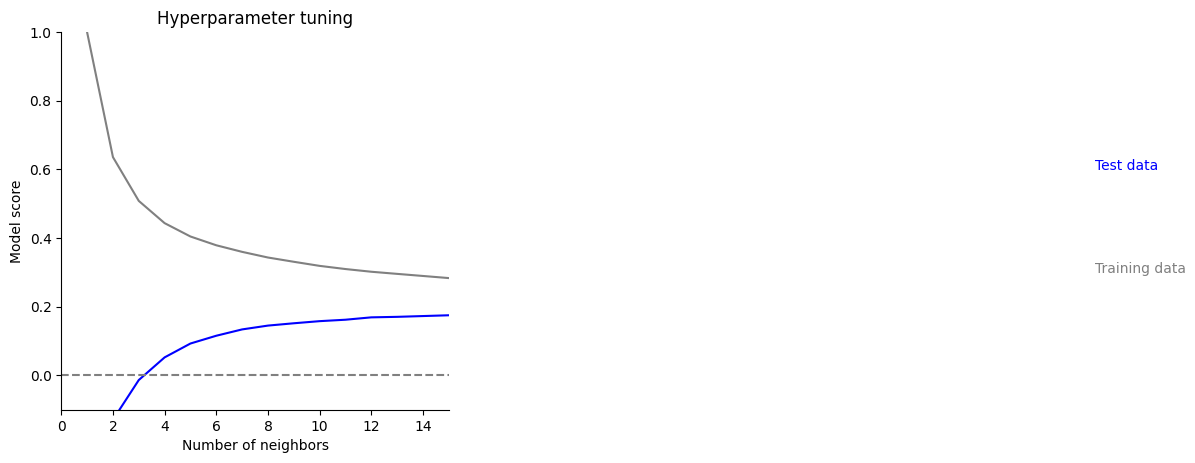

In [136]:
import matplotlib.pyplot as plt
plt.rc("axes.spines", top=False, right=False)
plt.rcParams['figure.figsize'] = [5,5]
plt.rcParams['figure.dpi'] = 100

plt.plot(n, train2, color="grey")
plt.plot(n, test2, color="blue")
plt.plot([0, test_range], [0, 0], color="grey", linestyle="--")
plt.xlim([0, test_range])
plt.ylim([-.1, 1])
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.text(40, .3, "Training data", color="grey")
plt.text(40, .6, "Test data", color="blue")
plt.title("Hyperparameter tuning")
None

In [198]:
import winsound
winsound.Beep(600,1100)
winsound.Beep(498,1100)
winsound.Beep(400,1200)

In [134]:
print("\a")
print("\a")






In [ ]:
y_test_predict = model.predict(X_test)

In [ ]:
pd.DataFrame([y_test_predict]).transpose()

In [ ]:
df_check = X_test.copy() 

In [ ]:
df_check["prediction"] = y_test_predict

In [ ]:
df_check.loc[df_check["ship_delay"]!=df_check["prediction"]]

In [ ]:
type(result_test)

In [ ]:
result_test

In [ ]:
model = KNeighborsRegressor(n_neighbors=4).fit(X_train_num, y_train)
y_train_predict = model.predict(X_train_num)
